# 5.3 Using a pretrained net

A common and highly effective approach to deep learning on small image datasets is
to use a pretrained network. A *pretrained network* is a saved network that was previously
trained on a large dataset, typically on a large-scale image-classification task. If this
original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the
visual world, and hence its features can prove useful for many different computervision problems, even though these new problems may involve completely different
classes than those of the original task. For instance, you might train a network on
ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in
images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it
makes deep learning very effective for small-data problems.

 In this case, let’s consider a large convnet trained on the ImageNet dataset
(1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to
perform well on the dogs-versus-cats classification problem.

 You’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew
Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet.
Although it’s an older model, far from the current state of the art and somewhat
heavier than many other recent models, I chose it because its architecture is similar to
what you’re already familiar with and is easy to understand without introducing any
new concepts. This may be your first encounter with one of these cutesy model
names—VGG, ResNet, Inception, Inception-ResNet, Xception, and so on; you’ll get
used to them, because they will come up frequently if you keep doing deep learning
for computer vision.

 There are two ways to use a pretrained network: *feature extraction* and *fine-tuning*.
We’ll cover both of them. Let’s start with feature extraction.

## 5.3.1 Feature extraction

Feature extraction consists of using the representations learned by a previous network
to extract interesting features from new samples. These features are then run through
a new classifier, which is trained from scratch.
 As you saw previously, convnets used for image classification comprise two parts:
they start with a series of pooling and convolution layers, and they end with a densely
connected classifier. The first part is called the *convolutional base* of the model. In the
case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

### *Why only reuse the convolutional base?*

Could you reuse the densely connected classifier as well? In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore
more reusable: the feature maps of a convnet are presence maps of generic concepts
over a picture, which is likely to be useful regardless of the computer-vision problem at
hand. But the representations learned by the classifier will necessarily be specific to the
set of classes on which the model was trained—they will only contain information about
the presence probability of this or that class in the entire picture. Additionally, representations found in densely connected layers no longer contain any information about
where objects are located in the input image: these layers get rid of the notion of space,
whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless.

Note that the level of generality (and therefore reusability) of the representations
extracted by specific convolution layers depends on the depth of the layer in the
model. Layers that come earlier in the model extract local, highly generic feature
maps (such as visual edges, colors, and textures), whereas layers that are higher up
extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset
differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than
using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat classes,
it’s likely to be beneficial to reuse the information contained in the densely connected
layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the
original model. Let’s put this in practice by using the convolutional base of the VGG16
network, trained on ImageNet, to extract interesting features from cat and dog
images, and then train a dogs-versus-cats classifier on top of these features.
 
 The VGG16 model, among others, comes prepackaged with Keras. You can import
it from the `keras.applications` module. Here’s the list of image-classification
models (all pretrained on the ImageNet dataset) that are available as part of `keras.applications`:
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

Let’s instantiate the VGG16 model.

### *Instantiating the VGG16 convolutional base*

In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


You pass three arguments to the constructor:
- `weights` specifies the weight checkpoint from which to initialize the model.
- `include_top` refers to including (or not) the densely connected classifier on
top of the network. By default, this densely connected classifier corresponds to
the 1,000 classes from ImageNet. Because you intend to use your own densely
connected classifier (with only two classes: cat and dog), you don’t need to
include it.
- `input_shape` is the shape of the image tensors that you’ll feed to the network.
This argument is purely optional: if you don’t pass it, the network will be able to
process inputs of any size.

Here’s the detail of the architecture of the VGG16 convolutional base. It’s similar to
the simple convnets you’re already familiar with:

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll
stick a densely connected classifier.
 At this point, there are two ways you could proceed:
- Running the convolutional base over your dataset, recording its output to a
Numpy array on disk, and then using this data as input to a standalone, densely
connected classifier similar to those you saw in part 1 of this book. This solution
is fast and cheap to run, because it only requires running the convolutional
base once for every input image, and the convolutional base is by far the most
expensive part of the pipeline. But for the same reason, this technique won’t
allow you to use data augmentation.
- Extending the model you have (`conv_base`) by adding `Dense` layers on top, and
running the whole thing end to end on the input data. This will allow you to use
data augmentation, because every input image goes through the convolutional
base every time it’s seen by the model. But for the same reason, this technique is
far more expensive than the first.
We’ll cover both techniques. Let’s walk through the code required to set up the first
one: recording the output of `conv_base` on your data and using these outputs as
inputs to a new model.

## Fast feature extraction without data augmentation

You’ll start by running instances of the previously introduced `ImageDataGenerator` to
extract images as Numpy arrays as well as their labels. You’ll extract features from
these images by calling the `predict` method of the `conv_base` model.

### *Copying images to training, validation, and test directories*

In [4]:
import os, shutil

#Path to the directory where the original dataset was uncompressed
original_dataset_dir = '/kaggle/input/dogs-vs-cats/train/train'

# Directory where you'll store your smaller dataset
base_dir = '/kaggle/working/cats_and_dogs_small'
os.mkdir(base_dir)

# Directories for the training, validation, and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directories with training cat pictures and dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directories with validation cat pictures and dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directories with test cat pictures and dog pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copies the first 1000 cat images to train_cat_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copies the first 1,000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copies the next 500 dog images to validation_dogs_dir    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copies the next 500 dog images to test_dogs_dir  
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


### *Extracting features using the pretrained convolutional base*

In [6]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/kaggle/working/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i+= 1
        # Note that because generators yield data indefinitely in a loop, you must break after every image has been seen once.
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step


The extracted features are currently of shape `(samples, 4, 4, 512)`. You’ll feed them
to a densely connected classifier, so first you must flatten them to `(samples, 8192)`:

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### *Defining and training the densely connected classifier*

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5839 - acc: 0.6855 - val_loss: 0.4429 - val_acc: 0.8360
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4187 - acc: 0.8115 - val_loss: 0.3614 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3590 - acc: 0.8470 - val_loss: 0.3254 - val_acc: 0.8740
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3172 - acc: 0.8665 - val_loss: 0.2996 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3013 - acc: 0.8760 - val_loss: 0.2853 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2634 - acc: 0.8915 - val_loss: 0.2797 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2446 - acc: 0.9040 - val_loss: 0.2684 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

### *Plotting the results*

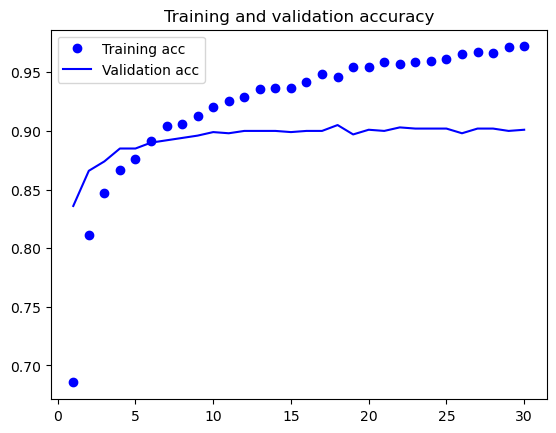

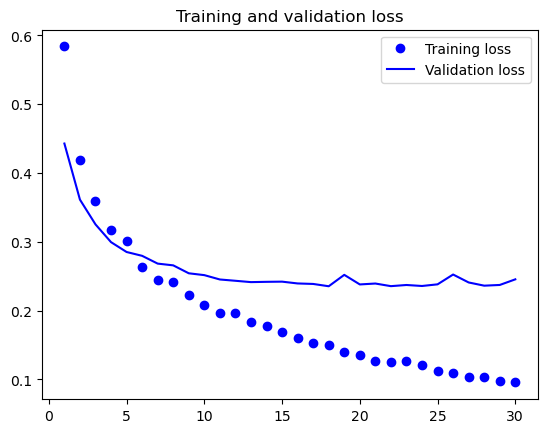

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Kojiro's note**: I reach a validation accuracy of about 90%—much better than I achieved in the
previous section with the small model trained from scratch. However, my plots don't indicate the overfitting problem as those in the original book; the validation acc and loss don't oscillate as roughly as Chollet's.
## Feature extraction with data augmentation

Now, let’s review the second technique I mentioned for doing feature extraction,
which is much slower and more expensive, but which allows you to use data augmentation during training: extending the `conv_base` model and running it end to end on
the inputs.

### *Adding a densely connected classifier on top of the convolutional base*

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is
very large. The classifier you’re adding on top has 2 million parameters.

 Before you compile and train the model, it’s very important to freeze the convolutional base. *Freezing* a layer or set of layers means preventing their weights from being
updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because
the `Dense` layers on top are randomly initialized, very large weight updates would be
propagated through the network, effectively destroying the representations previously
learned.

 In Keras, you freeze a network by setting its `trainable` attribute to `False`:

In [11]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that you added will be
trained. That’s a total of four weight tensors: two per layer (the main weight matrix
and the bias vector). Note that in order for these changes to take effect, you must first
compile the model. If you ever modify weight trainability after compilation, you
should then recompile the model, or these changes will be ignored.

 Now you can start training your model, with the same data-augmentation configuration that you used in the previous example.

### *Training the model end to end with a frozen convolutional base*

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
train_generator,
steps_per_epoch=2000//20,
epochs=30,
validation_data=validation_generator,
validation_steps=1000//20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 16s 149ms/step - loss: 0.5811 - acc: 0.6940 - val_loss: 0.4462 - val_acc: 0.8280
Epoch 2/30
100/100 [==============================] - 15s 152ms/step - loss: 0.4739 - acc: 0.7990 - val_loss: 0.3804 - val_acc: 0.8460
Epoch 3/30
100/100 [==============================] - 15s 148ms/step - loss: 0.4221 - acc: 0.8280 - val_loss: 0.3268 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 15s 147ms/step - loss: 0.4107 - acc: 0.8170 - val_loss: 0.3071 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 15s 145ms/step - loss: 0.3887 - acc: 0.8230 - val_loss: 0.2903 - val_acc: 0.8810
Epoch 6/30
100/100 [==============================] - 15s 153ms/step - loss: 0.3636 - acc: 0.8375 - val_loss: 0.2778 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 14s 145ms/step - loss: 0.3707 - acc: 0.8360 - val_lo

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


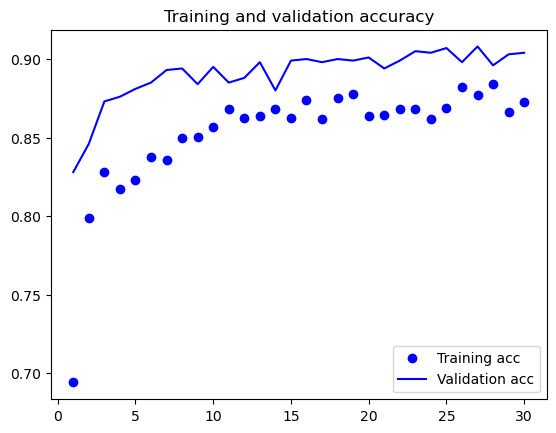

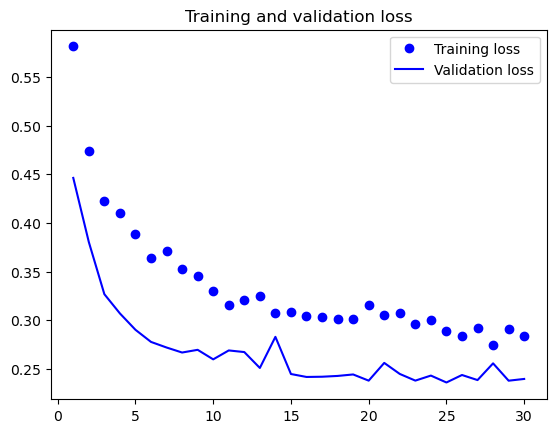

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Kojiro's note**: Let’s plot the results again. However, I cannot reach the validation accuracy of about 96% as in the book. 

## 5.3.2 Fine-tuning

Another widely used technique for model reuse, complementary to feature
extraction, is *fine-tuning*. Fine-tuning consists of unfreezing a few of
the top layers of a frozen model base used for feature extraction, and jointly training
both the newly added part of the model (in this case, the fully connected classifier)
and these top layers. This is called fine-tuning because it slightly adjusts the more
abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

I stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to
be able to train a randomly initialized classifier on top. For the same reason, it’s only
possible to fine-tune the top layers of the convolutional base once the classifier on top
has already been trained. If the classifier isn’t already trained, then the error signal
propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the
steps for fine-tuning a network are as follow:
1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part you added.

You already completed the first three steps when doing feature extraction. Let’s proceed with step 4: you’ll unfreeze your `conv_base` and then freeze individual layer inside it.
 As a reminder, this is what your convolutional base looks like:

In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

You’ll fine-tune the last three convolutional layers, which means all layers up to
`block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2`, and
`block5_conv3` should be trainable.

 Why not fine-tune more layers? Why not fine-tune the entire convolutional base?
You could. But you need to consider the following:
- Earlier layers in the convolutional base encode more-generic, reusable features,
whereas layers higher up encode more-specialized features. It’s more useful to
fine-tune the more specialized features, because these are the ones that need to
be repurposed on your new problem. There would be fast-decreasing returns in
fine-tuning lower layers.
- The more parameters you’re training, the more you’re at risk of overfitting.
The convolutional base has 15 million parameters, so it would be risky to
attempt to train it on your small dataset.

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers
in the convolutional base. Let’s set this up, starting from where you left off in the previous example.

### *Freezing all layers up to a specific one*

In [16]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now you can begin fine-tuning the network. 
<div class='alert alert-block alert-info'>
You’ll do this with the RMSProp optimizer, using a very low learning rate. The reason for using a low learning rate is that
you want to limit the magnitude of the modifications you make to the representations
of the three layers you’re fine-tuning. Updates that are too large may harm these representations.
</div>

### *Fine-tuning the model*

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=2000//20,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=1000//20)

Epoch 1/100
100/100 [==============================] - 18s 161ms/step - loss: 0.2935 - acc: 0.8705 - val_loss: 0.2193 - val_acc: 0.9110
Epoch 2/100
100/100 [==============================] - 16s 162ms/step - loss: 0.2537 - acc: 0.8920 - val_loss: 0.2128 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 15s 153ms/step - loss: 0.2434 - acc: 0.9055 - val_loss: 0.2183 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 16s 157ms/step - loss: 0.2208 - acc: 0.9060 - val_loss: 0.2071 - val_acc: 0.9150
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 0.2029 - acc: 0.9170 - val_loss: 0.2001 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 15s 150ms/step - loss: 0.1833 - acc: 0.9185 - val_loss: 0.2170 - val_acc: 0.9180
Epoch 7/100
100/100 [==============================] - 15s 147ms/step - loss: 0.1830 - acc: 0.9285 - val_loss: 0.1874 - val_acc: 0.9290
Epoch 8/100
100/100 [===========================

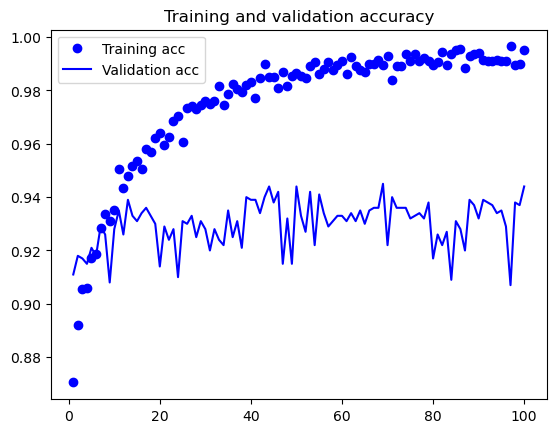

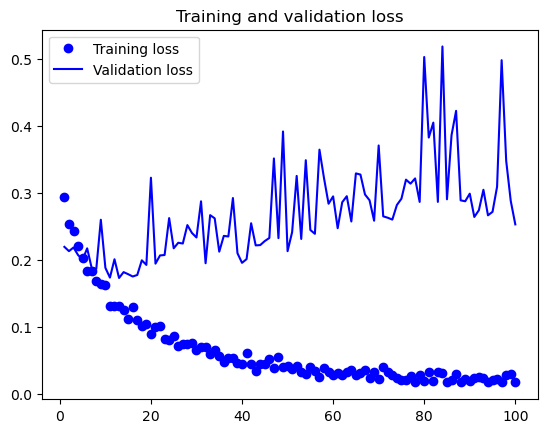

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### *Smoothing the plots*

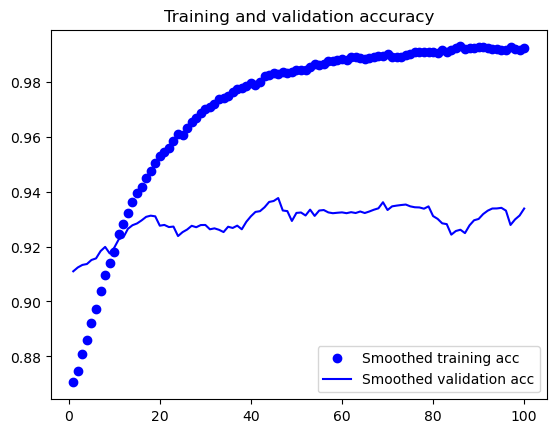

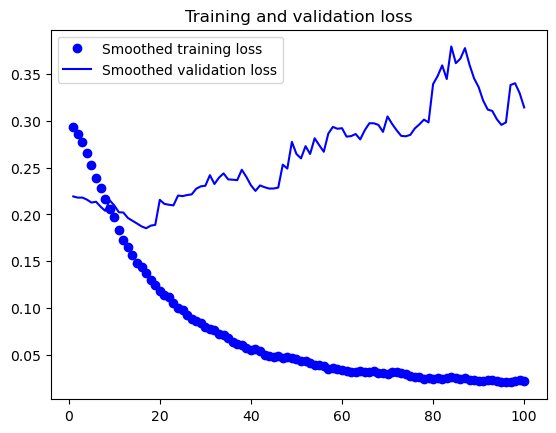

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Kojiro's note**: The validation accuracy curve look much cleaner. There is a nice
improvement in accuracy, from about 93% to 94% (still not as good as the author's accuracy).

 Note that the loss curve doesn’t show any real improvement (in fact, it’s deteriorating). You may wonder, how could accuracy stay stable or improve if the loss isn’t
decreasing? The answer is simple: what you display is an average of pointwise loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability
predicted by the model. The model may still be improving even if this isn’t reflected
in the average loss.
 You can now finally evaluate this model on the test data:

In [20]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=1000//20)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 38ms/step - loss: 0.3003 - acc: 0.9430
test acc: 0.9430000185966492


## 5.3.3 Wrapping up

Here’s what you should take away from the exercises in the past two sections:

- Convnets are the best type of machine-learning models for computer-vision
tasks. It’s possible to train one from scratch even on a very small dataset, with
decent results.
- On a small dataset, overfitting will be the main issue. Data augmentation is a
powerful way to fight overfitting when you’re working with image data.
- It’s easy to reuse an existing convnet on a new dataset via feature extraction.
This is a valuable technique for working with small image datasets.
- As a complement to feature extraction, you can use fine-tuning, which adapts to
a new problem some of the representations previously learned by an existing
model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image-classification problems—in
particular with small datasets. 